In [9]:
####nohup cmnd
####nohup python3 -u SRGAN_Train.py > result.txt
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import requests
import tqdm
import os
import shutil
import re
import cv2
import time
import logging

In [10]:
class TqdmLoggingHandler(logging.Handler):
    def __init__(self, level=logging.NOTSET):
        super().__init__(level)

    def emit(self, record):
        try:
            msg = self.format(record)
            tqdm.tqdm.write(msg)
            self.flush()
        except (KeyboardInterrupt, SystemExit):
            raise
        except:
            self.handleError(record)  
log = logging.getLogger(__name__)
log.setLevel(logging.INFO)
log.addHandler(TqdmLoggingHandler())

In [11]:
imgs_path="images/"
from tensorflow.keras.utils import image_dataset_from_directory as img_from_dir

In [13]:
len(os.listdir(imgs_path))

10000

In [14]:
train_data=img_from_dir(imgs_path,label_mode=None,
                                 batch_size=1,image_size=(128,128),
                                 validation_split=0.05,subset='training',
                                 seed=123).take(5000)
test_data=img_from_dir(imgs_path,label_mode=None, 
                                 batch_size=1,image_size=(128,128), 
                                 validation_split=0.05,subset='validation',
                                 seed=123).take(500)

Found 10000 files belonging to 1 classes.
Using 9500 files for training.
Found 10000 files belonging to 1 classes.
Using 500 files for validation.


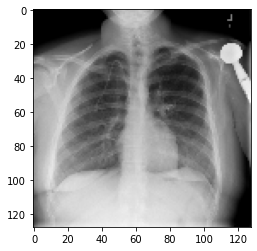

In [15]:
for x in train_data.take(1):
    plt.imshow(x[0]/255)
    plt.show()

In [16]:
tqdm.tqdm(train_data)

  0%|                                                                                          | 0/2000 [00:00<?, ?it/s]

In [17]:
@tf.function
def build_data(data):
  cropped=tf.dtypes.cast(tf.image.random_crop(data[0] / 255,(128,128,3)),tf.float32)

  lr=tf.image.resize(cropped,(32,32))
  return (lr,cropped)

In [18]:
def bicubic_interpolate(image,shape):
  img_resized=cv2.resize(image,shape, interpolation=cv2.INTER_CUBIC)
  return img_resized

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
LR


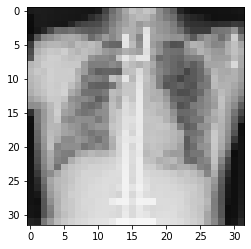

Bicubic


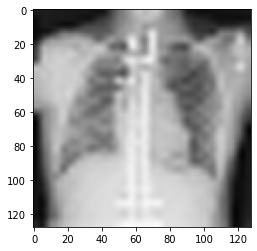

HR


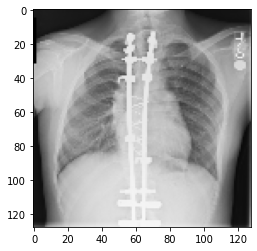

In [19]:
train_dataset_mapped = train_data.map(build_data,num_parallel_calls=tf.data.AUTOTUNE)
for x in train_dataset_mapped.take(1):
    print("LR")
    plt.imshow(x[0].numpy())
    plt.show()
    print("Bicubic")
    plt.imshow(bicubic_interpolate(x[0].numpy(),(128,128)))
    plt.show()
    print("HR")
    plt.imshow(x[1].numpy())
    plt.show()
    

In [20]:
def residual_block_gen(ch=64,k_s=3,st=1):
  model=tf.keras.Sequential([
    tf.keras.layers.Conv2D(ch,k_s,strides=(st,st),padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Conv2D(ch,k_s,strides=(st,st),padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(),
  ])
  return model

def Upsample_block(x, ch=256, k_s=3, st=1):
    x = tf.keras.layers.Conv2D(ch,k_s, strides=(st,st), padding='same')(x)
    x = tf.nn.depth_to_space(x, 2) # Subpixel pixelshuffler
    x = tf.keras.layers.LeakyReLU()(x)
    return x

input_lr=tf.keras.layers.Input(shape=(None,None,3))
input_conv=tf.keras.layers.Conv2D(64,9,padding='same')(input_lr)
input_conv=tf.keras.layers.LeakyReLU()(input_conv)

SRRes=input_conv
for x in range(5):
  res_output=residual_block_gen()(SRRes)
  SRRes=tf.keras.layers.Add()([SRRes,res_output])

SRRes=tf.keras.layers.Conv2D(64,9,padding='same')(SRRes)
SRRes=tf.keras.layers.BatchNormalization()(SRRes)

SRRes=tf.keras.layers.Add()([SRRes,input_conv])

SRRes=Upsample_block(SRRes)
SRRes=Upsample_block(SRRes)

output_sr=tf.keras.layers.Conv2D(3,9,activation='tanh',padding='same')(SRRes)

SRResnet=tf.keras.models.Model(input_lr,output_sr)

In [21]:
def residual_block_disc(ch=64,k_s=3,st=1):
  model=tf.keras.Sequential([
    tf.keras.layers.Conv2D(ch,k_s,strides=(st,st),padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(),
  ])
  return model

input_lr=tf.keras.layers.Input(shape=(128,128,3))
input_conv=tf.keras.layers.Conv2D(64,3,padding='same')(input_lr)
input_conv=tf.keras.layers.LeakyReLU()(input_conv)

channel_nums=[64,128,128,256,256,512,512]
stride_sizes=[2,1,2,1,2,1,2]

disc=input_conv
for x in range(7):
  disc=residual_block_disc(ch=channel_nums[x],st=stride_sizes[x])(disc)
  
disc=tf.keras.layers.Flatten()(disc)

disc=tf.keras.layers.Dense(1024)(disc)
disc=tf.keras.layers.LeakyReLU()(disc)

disc_output=tf.keras.layers.Dense(1,activation='sigmoid')(disc)

discriminator=tf.keras.models.Model(input_lr,disc_output)

2022-04-13 05:15:06.961993: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 134217728 exceeds 10% of free system memory.
2022-04-13 05:15:06.980672: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 134217728 exceeds 10% of free system memory.
2022-04-13 05:15:06.990559: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 134217728 exceeds 10% of free system memory.


In [22]:
def PSNR(y_true,y_pred):
  mse=tf.reduce_mean( (y_true - y_pred) ** 2 )
  return 20 * log10(1 / (mse ** 0.5))

def log10(x):
  numerator = tf.math.log(x)
  denominator = tf.math.log(tf.constant(10, dtype=numerator.dtype))
  return numerator / denominator

def pixel_MSE(y_true,y_pred):
  return tf.reduce_mean( (y_true - y_pred) ** 2 )

In [23]:
VGG19=tf.keras.applications.VGG19(weights='imagenet',include_top=False,input_shape=(128,128,3))

VGG_i,VGG_j=2,2
def VGG_loss(y_hr,y_sr,i_m=2,j_m=2):
  i,j=0,0
  accumulated_loss=0.0
  for l in VGG19.layers:
    cl_name=l.__class__.__name__
    if cl_name=='Conv2D':
      j+=1
    if cl_name=='MaxPooling2D':
      i+=1
      j=0
    if i==i_m and j==j_m:
      break
    
    y_hr=l(y_hr)
    y_sr=l(y_sr)
    if cl_name=='Conv2D':
      accumulated_loss+=tf.reduce_mean((y_hr-y_sr)**2) * 0.006

  return accumulated_loss
def VGG_loss_intuitive(y_true,y_pred):
  accumulated_loss=0.0
  for l in VGG19.layers:
    y_true=l(y_true)
    y_pred=l(y_pred)
    accumulated_loss+=tf.reduce_mean((y_true-y_pred)**2) * 0.006
  return accumulated_loss

In [24]:
generator_optimizer=tf.keras.optimizers.SGD(0.0001)
discriminator_optimizer=tf.keras.optimizers.SGD(0.0001)

adv_ratio=0.001
evaluate=['PSNR']
# MSE
loss_func,adv_learning = pixel_MSE,False
# VGG2.2
loss_func,adv_learning = lambda y_hr,y_sr:VGG_loss(y_hr,y_sr,i_m=2,j_m=2),False
# VGG 5.4
loss_func,adv_learning = lambda y_hr,y_sr:VGG_loss(y_hr,y_sr,i_m=5,j_m=4),False
# SRGAN-MSE
loss_func,adv_learning = pixel_MSE,True
# SRGAN-VGG 2.2generator_optimizer=tf.keras.optimizers.SGD(0.0001)
discriminator_optimizer=tf.keras.optimizers.SGD(0.0001)

adv_ratio=0.001
evaluate=['PSNR']
# MSE
loss_func,adv_learning = pixel_MSE,False
# VGG2.2
loss_func,adv_learning = lambda y_hr,y_sr:VGG_loss(y_hr,y_sr,i_m=2,j_m=2),False
# VGG 5.4
loss_func,adv_learning = lambda y_hr,y_sr:VGG_loss(y_hr,y_sr,i_m=5,j_m=4),False
# SRGAN-MSE
loss_func,adv_learning = pixel_MSE,True
# SRGAN-VGG 2.2
loss_func,adv_learning = lambda y_hr,y_sr:VGG_loss(y_hr,y_sr,i_m=2,j_m=2),True
# SRGAN-VGG 5.4
loss_func,adv_learning = lambda y_hr,y_sr:VGG_loss(y_hr,y_sr,i_m=5,j_m=4),True

#Real loss
loss_func,adv_learning = lambda y_hr,y_sr:VGG_loss(y_hr,y_sr,i_m=5,j_m=4),True
loss_func,adv_learning = lambda y_hr,y_sr:VGG_loss(y_hr,y_sr,i_m=2,j_m=2),True
# SRGAN-VGG 5.4
loss_func,adv_learning = lambda y_hr,y_sr:VGG_loss(y_hr,y_sr,i_m=5,j_m=4),True

#Real loss
loss_func,adv_learning = lambda y_hr,y_sr:VGG_loss(y_hr,y_sr,i_m=5,j_m=4),True

In [25]:
cross_entropy = tf.keras.losses.BinaryCrossentropy()
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

@tf.function()
def train_step(data,loss_func=pixel_MSE,adv_learning=True,evaluate=['PSNR'],adv_ratio=0.001):
  logs={}
  gen_loss,disc_loss=0,0

  low_resolution,high_resolution=data
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    super_resolution = SRResnet(low_resolution, training=True)
    gen_loss=loss_func(high_resolution,super_resolution)

    logs['reconstruction']=gen_loss

    if adv_learning:
      real_output = discriminator(high_resolution, training=True)
      fake_output = discriminator(super_resolution, training=True)
      
      adv_loss_g = generator_loss(fake_output) * adv_ratio
      gen_loss += adv_loss_g

      disc_loss = discriminator_loss(real_output, fake_output)
      
      logs['adv_g']=adv_loss_g
      logs['adv_d']=disc_loss

  gradients_of_generator = gen_tape.gradient(gen_loss, SRResnet.trainable_variables)
  generator_optimizer.apply_gradients(zip(gradients_of_generator, SRResnet.trainable_variables))

  if adv_learning:
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
  for x in evaluate:
    if x=='PSNR':
      logs[x]=PSNR(high_resolution,super_resolution)

  return logs

In [26]:
tf.config.experimental_run_functions_eagerly(True)
tf.config.run_functions_eagerly(True)

Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.


In [ ]:
for x in range(50):
  train_dataset_mapped = train_data.map(build_data,num_parallel_calls=tf.data.AUTOTUNE).batch(10)
  val_dataset_mapped = test_data.map(build_data,num_parallel_calls=tf.data.AUTOTUNE).batch(10)
  for image_batch in tqdm.tqdm(train_dataset_mapped, position=0, leave=True):
    logs=train_step(image_batch,loss_func,adv_learning,evaluate,adv_ratio)
  if x%2==0:
    SRResnet.save(f'/DATA/vardhan1/SISR/SRGAN/SRNet_gen_{x}_Epoch_23_04.h5')
    discriminator.save(f'/DATA/vardhan1/SISR/SRGAN/SRNet_disc_{x}_Epoch_23_04.h5')

  0%|                                                                                           | 0/200 [00:00<?, ?it/s]2022-04-13 05:16:31.446962: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 134217728 exceeds 10% of free system memory.
2022-04-13 05:16:34.820927: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 339738624 exceeds 10% of free system memory.
  3%|██▍                                                                                | 6/200 [01:04<33:57, 10.50s/it]

In [ ]:
SRResnet.save('SRGAN/SRResNet-generator.h5')
discriminator.save('SRGAN/SRResNet-discriminator.h5')